Importing the packages

In [1]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform, pdist
from io import StringIO

from sklearn.metrics import silhouette_score
from geopy.distance import geodesic
import matplotlib.cm as cm 
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from math import radians, sin, cos, sqrt, atan2
from networkx.algorithms.community import greedy_modularity_communities
import pickle

import spacy
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import geopandas as gpd
import networkx as nx
import seaborn as sns
import numpy as np
from collections import Counter

from geopy.distance import geodesic
from Levenshtein import distance
from haversine import haversine, Unit

from collections import Counter
import pandas as pd
import geopandas as gpd
import folium
# Use a boundary dataset (e.g. from the Finnish statistical office or OpenStreetMap)
# For now, let's use OSM via GeoPandas and `geopy` for bounding box
from shapely.geometry import box
from geopy.geocoders import Nominatim

import osmnx as ox
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox

In [2]:
# Load world cities and filter for Helsinki
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
helsinki = world[world.name == "Helsinki"]



geolocator = Nominatim(user_agent="geoapi")
location = geolocator.geocode("Helsinki, Finland")
lat, lon = location.latitude, location.longitude

# Create a bounding box around Helsinki (approx 0.1 degrees buffer)
bbox = box(lon - 0.1, lat - 0.1, lon + 0.1, lat + 0.1)

# Use Geopandas to query from a global OSM polygon source (like `geopandas.read_file(URL)` if you have one)
# But here's a better way using OSMnx:

# Get the boundary polygon from OpenStreetMap
helsinki_polygon = ox.geocode_to_gdf("Helsinki, Finland")

# Create a folium map centered on Helsinki
m = folium.Map(location=[lat, lon], zoom_start=11)

# Add the Helsinki boundary to the map
folium.GeoJson(helsinki_polygon.geometry.iloc[0]).add_to(m)

# Show map (in Jupyter or save to HTML)
m


/tmp/ipykernel_634161/2526756631.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


In [3]:
df_common = pd.DataFrame()
file_path = "/mnt/common-ssd/mizsakma/Multilin_15p_concept/multilin_15_city/Helsinki/gtfs_helsinki_17_ok_19/stops.txt"
df_common = pd.read_csv(file_path)
df_common['stop_id'] = df_common['stop_id'].astype(str)
df_common = df_common.drop_duplicates()

In [4]:
# Load stops.txt
file_path = "/mnt/common-ssd/mizsakma/Multilin_15p_concept/multilin_15_city/Helsinki/gtfs_helsinki_17_ok_19/stops.txt"
df_common = pd.read_csv(file_path)
df_common['stop_id'] = df_common['stop_id'].astype(str)
df_common = df_common.drop_duplicates()

# Create GeoDataFrame from GTFS stops
geometry = [Point(xy) for xy in zip(df_common['stop_lon'], df_common['stop_lat'])]
gdf_stops = gpd.GeoDataFrame(df_common, geometry=geometry, crs="EPSG:4326")

# Get the Helsinki boundary polygon
helsinki_polygon = ox.geocode_to_gdf("Helsinki, Finland")
helsinki_shape = helsinki_polygon.geometry.iloc[0]

# Filter only stops within the Helsinki polygon
gdf_filtered = gdf_stops[gdf_stops.geometry.within(helsinki_shape)]

# Drop geometry and update df_common
df_common = gdf_filtered.drop(columns='geometry').reset_index(drop=True)
df_common['stop_name'] = df_common['stop_name'].apply(
    lambda name: name[:-4] if name.endswith('(M)') else name
)
df_common['stop_id'].nunique()

2880

In [5]:
import folium

center_lat = df_common['stop_lat'].mean()
center_lon = df_common['stop_lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles='cartodbpositron')

for _, row in df_common.iterrows():
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=row['stop_name'] 
    ).add_to(m)

m

In [6]:
n = df_common.shape[0]
levh_matrix = np.zeros((n, n))
val = df_common['stop_name']

for i, stop_name_i in tqdm(enumerate(val)):
    for j, stop_name_j in enumerate(val):
        levh_matrix[i][j] = distance(stop_name_i, stop_name_j)

2880it [00:09, 306.55it/s]


In [7]:
coords = df_common[['stop_lat', 'stop_lon']].to_numpy()
haversine_matrix = np.zeros((len(coords), len(coords)))

for i in tqdm(range(len(coords))):
    for j in range(len(coords)):
        if i != j:
            haversine_matrix[i][j] = haversine(coords[i], coords[j], unit=Unit.KILOMETERS)

100%|██████████| 2880/2880 [00:39<00:00, 73.64it/s]


In [8]:
nlp = spacy.load("en_core_web_md")

name_vectors = np.array([nlp(name).vector for name in df_common['stop_name']])

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Flatten the matrix, normalize, then reshape back
def normalize_matrix(matrix):
    scaler = MinMaxScaler()
    flat = matrix.reshape(-1, 1)  # make it 2D
    normalized = scaler.fit_transform(flat)
    return normalized.reshape(matrix.shape)

# Apply normalization
haversine_norm = normalize_matrix(haversine_matrix)
levh_norm = normalize_matrix(levh_matrix)
combined_matrix = haversine_matrix * 0.6 + levh_matrix * 0.4

In [10]:
name_sim_matrix = cosine_similarity(name_vectors)  # values from -1 to 1
name_sim_matrix
name_sim_matrix = (name_sim_matrix + 1) / 2
name_sim_matrix = normalize_matrix(name_sim_matrix)
combined_matrix = haversine_matrix * 0.7 +  (1 - name_sim_matrix) * 0.3

In [11]:
linkage_matrix = linkage(combined_matrix, method='single')

In [12]:
num_cluster_list = []
sil_scores = []
thresholds = np.arange(0, 30, 0.05)

for i in tqdm(thresholds):

    clusters = fcluster(linkage_matrix, t=i, criterion='distance')
    num_clusters = len(set(clusters))
    num_cluster_list.append((num_clusters))

    clusters = fcluster(linkage_matrix, t=i, criterion='distance')
    
    sil_score = silhouette_score(combined_matrix, clusters)
    
    sil_scores.append(sil_score)

optimal_threshold = thresholds[np.argmax(sil_scores)]
print(optimal_threshold)
print(f"Number of clusters: {num_clusters}")

100%|██████████| 600/600 [02:40<00:00,  3.74it/s]

2.9000000000000004
Number of clusters: 4


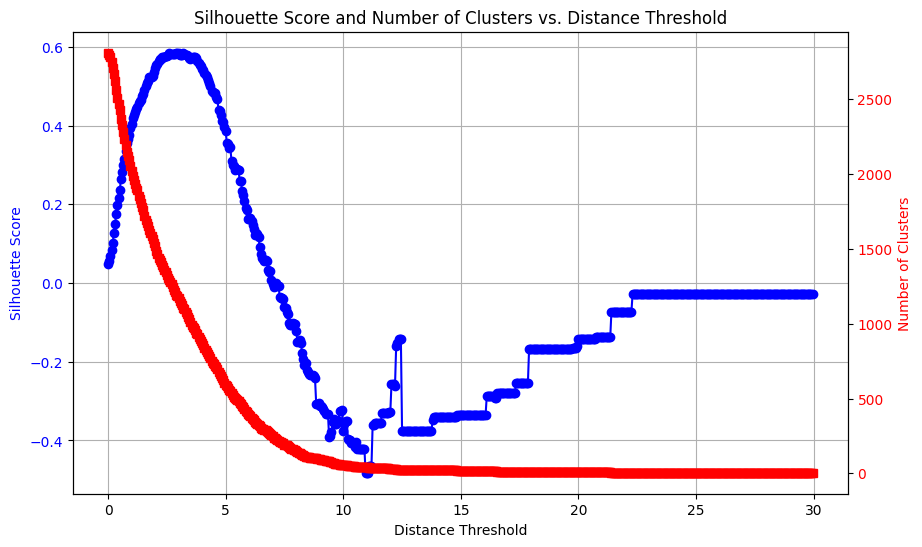

In [13]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot silhouette scores on the primary y-axis
ax1.plot(thresholds, sil_scores, marker='o', color='blue', label='Silhouette Score')
ax1.set_xlabel("Distance Threshold")
ax1.set_ylabel("Silhouette Score", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(thresholds, num_cluster_list, marker='s', color='red', linestyle='--', label='Number of Clusters')
ax2.set_ylabel("Number of Clusters", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and grid
plt.title("Silhouette Score and Number of Clusters vs. Distance Threshold")
ax1.grid(True)

# Show the plot
plt.show()

In [14]:
with open('Helsinki_linkage_matrix.pkl', 'wb') as f:
    pickle.dump(linkage_matrix, f)

#with open('Helsinki_linkage_matrix.pkl', 'rb') as f:
#    linkage_matrix = pickle.load(f)

In [15]:
optimal_threshold

2.9000000000000004

In [16]:
selected_threshold = 2.9000000000000004 #
clusters = fcluster(linkage_matrix, t=selected_threshold, criterion='distance')
num_clusters = len(set(clusters))

#num_cluster_list.append((i, num_clusters))
#print(f"Number of clusters: {num_clusters}")

df_common['clust'] = clusters
print(df_common['clust'].nunique(), df_common['stop_id'].nunique())

1195 2880


In [17]:
myprojection_latlong_2 = 4326
stops = gpd.GeoDataFrame(geometry = gpd.points_from_xy(df_common["stop_lon"], df_common["stop_lat"]), crs = myprojection_latlong_2)

def calculate_geodesic_distance(point1, point2):
    return geodesic((point1.y, point1.x), (point2.y, point2.x)).meters

stops = gpd.GeoDataFrame(geometry=stops["geometry"])
stops.crs = myprojection_latlong_2
stops = stops.to_crs(myprojection_latlong_2)

num_points = len(stops)
geodesic_distance_matrix = np.zeros((num_points, num_points))

# calculating geodesic distances between pairs of points represented by longitude and latitude coordinates.
#The distance matrix initialized here will be populated with actual distance values in subsequent step

# Creating dictionaries the the stops's parent station ID and the parent station ID's 

In [18]:
def calculate_geodesic_distance(point1, point2):
    return geodesic(point1, point2).meters

In [19]:
walking_speed = 5.1  # Walking speed in km/h
walking_speed_mps = walking_speed * 1000 / 3600  # Convert km/h to m/s

stop_pairs = df_common[['stop_id', 'stop_lat', 'stop_lon', 'clust']].drop_duplicates()

data = []

for clust, group in tqdm(stop_pairs.groupby('clust')):
    stop_ids = group['stop_id'].values
    coords = group[['stop_lat', 'stop_lon']].values

    for i in range(len(stop_ids)):
        for j in range(i + 1, len(stop_ids)):
            stop_id_1 = stop_ids[i]
            stop_id_2 = stop_ids[j]
            point1 = (coords[i][0], coords[i][1])
            point2 = (coords[j][0], coords[j][1])

            distance = calculate_geodesic_distance(point1, point2)

            if distance / walking_speed_mps <= 600:
                data.append((stop_id_1, stop_id_2, distance))
                data.append((stop_id_2, stop_id_1, distance))

df_distances = pd.DataFrame(data, columns=['stop_id', 'stop_id_to', 'travel_duration'])
df_distances['travel_duration'] = df_distances['travel_duration'] / walking_speed

100%|██████████| 1195/1195 [00:01<00:00, 737.05it/s]


In [20]:
file_path = f"/mnt/common-ssd/mizsakma/Multilin_15p_concept/multilin_15_city/Helsinki/gtfs_helsinki_17_ok_19"

pure_stop_times = pd.read_csv(file_path + "/stop_times.txt", sep=",", dtype={'stop_headsign': 'object'})
pure_stop_times['stop_id'] = pure_stop_times['stop_id'].astype(str)

pure_stop_times = pure_stop_times[pure_stop_times['stop_id'].isin(df_common['stop_id'].unique())]

routes = pd.read_csv(file_path + "/routes.txt", sep=",")
trips = pd.read_csv(file_path + "/trips.txt", sep=",", dtype={'route_id': 'object'})

In [21]:
routes = routes[['route_id', 'route_type']]
routes['route_id'] = routes['route_id'].astype(str)

trips = trips[['route_id', 'trip_id', 'service_id', 'direction_id']]
trips['route_id'] = trips['route_id'].astype(str)

trips = pd.merge(trips, routes, on='route_id', how='right')
pure_stop_times = pure_stop_times.merge(trips[['trip_id', 'route_id', 'route_type', 'service_id', 'direction_id']], on='trip_id', how='left')

pure_stop_times['stop_id_to'] = pure_stop_times.groupby((['trip_id', 'service_id', 'route_id', 'route_type']))['stop_id'].shift(-1)
pure_stop_times['arrival_time_stop_to'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['arrival_time'].shift(-1)
pure_stop_times['distance_travaled'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['shape_dist_traveled'].shift(-1)

#deleting the terminals and loops
pure_stop_times = pure_stop_times[pure_stop_times['arrival_time_stop_to'].notna()]
pure_stop_times = pure_stop_times[pure_stop_times['departure_time'].notna()]
pure_stop_times = pure_stop_times[pure_stop_times['stop_id'] != pure_stop_times['stop_id_to']]

pure_stop_times['arrival_hour'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[0]))
pure_stop_times['arrival_minute'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[1]))
pure_stop_times['arrival_second'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[2]))

pure_stop_times['departure_hour'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[0]))
pure_stop_times['departure_minute'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[1]))
pure_stop_times['departure_second'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[2]))

pure_stop_times['arrival_time'] = pd.to_datetime({
    'year': 2019,  
    'month': 10,   
    'day': 17,      
    'hour':     pure_stop_times['arrival_hour'],
    'minute':   pure_stop_times['arrival_minute'],
    'second':   pure_stop_times['arrival_second'] })

pure_stop_times['departure_time'] = pd.to_datetime({
    'year':2019,
    'month':10,
    'day': 17,
    'hour':pure_stop_times['departure_hour'],
    'minute':pure_stop_times['departure_minute'],
    'second':pure_stop_times['departure_second']
})

pure_stop_times['arrival_time_only'] = pure_stop_times['arrival_time'].dt.time
pure_stop_times['departure_time_only'] = pure_stop_times['departure_time'].dt.time

In [22]:
pure_stop_times = pure_stop_times[pure_stop_times['departure_hour'] < 24]

pure_stop_times['edge_frequency'] = pure_stop_times.groupby(['departure_hour', 'route_id', 'stop_id', 'stop_id_to']).transform('size')
pure_stop_times['edge_frequency_trip'] = pure_stop_times.groupby(['departure_hour', 'stop_id', 'stop_id_to', 'trip_id']).transform('size')

pure_stop_times['travel_duration'] = pure_stop_times['arrival_time'] - pure_stop_times['departure_time']
pure_stop_times['travel_duration'] = pure_stop_times['travel_duration'].dt.total_seconds().astype(int)
pure_stop_times.loc[pure_stop_times['travel_duration'] == 0, 'travel_duration'] = 30
pure_stop_times['distance_travaled'] = pure_stop_times['distance_travaled'] - pure_stop_times['shape_dist_traveled']

In [23]:
# If these 3 are the same than there is no problem
print(pure_stop_times['stop_id'].nunique())
print(pure_stop_times[pure_stop_times['stop_id'].isin(df_common['stop_id'].unique())]['stop_id'].nunique())
print(df_common[df_common['stop_id'].isin(pure_stop_times['stop_id'].unique())]['stop_id'].nunique())

2763
2763
2763


# Multilinear dfs with time vehicle change

In [24]:
df_distances['route_id'] = 'walking'
df_distances['travel_duration'] = 180
df_distances = df_distances[df_distances['stop_id'].isin(pure_stop_times['stop_id'].unique())]

In [25]:
proba_network = nx.MultiDiGraph()

pure_stop_times_2 = pure_stop_times[pure_stop_times['departure_hour'] == 15][
    ['route_id', 'stop_id', 'stop_id_to', 'travel_duration', 'direction_id']
].drop_duplicates()

grouped_df = pure_stop_times_2.groupby(
    ['route_id', 'stop_id', 'stop_id_to', 'direction_id']
)['travel_duration'].mean().reset_index()

proba_stop_times = pd.concat([pure_stop_times_2, df_distances], ignore_index=True)

# Then, if needed, iterate over proba_stop_times
for idx, row in proba_stop_times.iterrows():
    proba_network.add_edge(
        row['stop_id'], 
        row['stop_id_to'], 
        weight=row['travel_duration'], 
        route_id=row['route_id']
    )

In [26]:
proba_stop_times['stop_id'].nunique()

2747

In [27]:
print('number of nodes:', nx.number_of_nodes(proba_network))
print('number of edges:', nx.number_of_edges(proba_network))

if not nx.is_strongly_connected(proba_network):
    sccs = list(nx.strongly_connected_components(proba_network))
    print(f"Number of strongly connected components: {len(sccs)}")

    largest_scc = max(sccs, key=len)
    print(f"Largest component size: {len(largest_scc)}")

    largest_component_network = proba_network.subgraph(largest_scc).copy()

    print('number of nodes in largest component:', nx.number_of_nodes(largest_component_network))
    print('number of edges in largest component:', nx.number_of_edges(largest_component_network))

number of nodes: 2864
number of edges: 20115
Number of strongly connected components: 156
Largest component size: 2696
number of nodes in largest component: 2696
number of edges in largest component: 18489


In [28]:
def find_all_paths_within_weight_limit(graph, start_node, weight_limit):
    def dfs(current_node, current_path, current_weight, visited, prev_route):
        # If the accumulated weight exceeds the limit, stop exploring this path.
        if current_weight > weight_limit:
            return

        # Mark the current node as reachable and record the current path.
        reachable_nodes.add(current_node)
        all_paths.append((list(current_path), current_weight))

        # Explore all neighbors (successors) of the current node.
        for neighbor in graph.successors(current_node):
            if neighbor not in visited:
                for edge_key in graph[current_node][neighbor]:
                    edge_data = graph[current_node][neighbor][edge_key]
                    edge_weight = edge_data['weight']
                    edge_route = edge_data['route_id']

                    # Base travel time
                    total_weight = current_weight + edge_weight

                    # Penalize route change, unless it's walking
                    if (
                        prev_route is not None and
                        edge_route != prev_route and
                        edge_route != 'walking' and
                        prev_route != 'walking'
                    ):
                        total_weight += 180  # transfer penalty

                    # Stop if weight limit exceeded
                    if total_weight > weight_limit:
                        continue

                    visited.add(neighbor)
                    current_path.append(neighbor)

                    # Recurse
                    dfs(neighbor, current_path, total_weight, visited, edge_route)

                    # Backtrack
                    current_path.pop()
                    visited.remove(neighbor)

    # Initialize
    all_paths = []
    reachable_nodes = set()

    # Start DFS
    dfs(start_node, [start_node], 0, set([start_node]), None)

    return all_paths, reachable_nodes


# Example usage:
paths, reachable_nodes = find_all_paths_within_weight_limit(largest_component_network, '1293155', 600)
print(f"Number of paths: {len(paths)}")
print(f"Reachable stops within 600s: {len(reachable_nodes)}")

Number of paths: 57835
Reachable stops within 600s: 84


In [29]:
results_dic = {}

for stop in tqdm(nx.nodes(largest_component_network)):
    results_dic[stop] = find_all_paths_within_weight_limit(largest_component_network, stop, 600)

100%|██████████| 2696/2696 [15:41<00:00,  2.86it/s]  


In [30]:
with open('Helsinki_10min_walkings.pkl', 'wb') as f:
    pickle.dump(results_dic, f)

In [31]:
df_common_centrality = df_common[df_common['stop_id'].isin(largest_component_network.nodes())].copy()

pure_stop_times_centrality = pd.merge(pure_stop_times, df_common_centrality[['stop_id', 'clust', 'stop_lat', 'stop_lon']], on = 'stop_id', how = 'left')

pure_stop_times_centrality['clust_id_to'] = pure_stop_times_centrality.groupby(
    ['route_id', 'trip_id', 'service_id', 'route_type']
)['clust'].shift(-1)

pure_stop_times_centrality = pure_stop_times_centrality[
    pure_stop_times_centrality['clust_id_to'] != pure_stop_times_centrality['clust']
].drop_duplicates()

pure_stop_times_centrality_graph = pure_stop_times_centrality[
    pure_stop_times_centrality['departure_hour'] == 15
][['clust', 'clust_id_to', 'travel_duration']].drop_duplicates()

pure_stop_times_centrality_graph = pure_stop_times_centrality_graph.groupby(
    ['clust', 'clust_id_to'], as_index=False
)['travel_duration'].mean()

full_graph = nx.from_pandas_edgelist(
    pure_stop_times_centrality_graph, 
    source='clust', 
    target='clust_id_to', 
    edge_attr='travel_duration',
    create_using=nx.Graph()
)

eigenvector_centrality = nx.eigenvector_centrality(full_graph, max_iter=1000)
degree_centrality = nx.degree_centrality(full_graph)
closeness_centrality = nx.closeness_centrality(full_graph)
betweenness_centrality = nx.betweenness_centrality(full_graph)

centrality_df = pd.DataFrame({
    "Node": list(full_graph.nodes()),
    "Eigenvector Centrality": [eigenvector_centrality[node] for node in full_graph.nodes()],
    "Degree Centrality": [degree_centrality[node] for node in full_graph.nodes()],
    "Closeness Centrality": [closeness_centrality[node] for node in full_graph.nodes()],
    "Betweenness Centrality": [betweenness_centrality[node] for node in full_graph.nodes()]
})

#df_common = df_common[df_common['stop_id'].isin(largest_component_network.nodes)]

centrality_df = pd.merge(centrality_df, df_common[['stop_id', 'clust', 'stop_lat', 'stop_lon', 'stop_name']], left_on = 'Node', right_on= 'clust', how = 'left')
centrality_df.to_csv("Helsinki_stops_with_centrality.csv", index=False)

In [ ]:
iwant an error here!

In [32]:
lahflkwa
import folium
filtered_df = df_common[df_common['stop_id'].isin(largest_component_network.nodes())]

stop_info_dict = {
    row['stop_id']: {
        'lat': row['stop_lat'],
        'lon': row['stop_lon'],
        'clust': row['clust']
    }
    for _, row in filtered_df.iterrows()
}

nx.set_node_attributes(largest_component_network, stop_info_dict)
center_lat = filtered_df['stop_lat'].mean()
center_lon = filtered_df['stop_lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Define a color palette for clusters
import matplotlib.cm as cm
import matplotlib.colors as colors

clusters = filtered_df['clust'].unique()
cmap = cm.get_cmap('tab10', len(clusters))
cluster_to_color = {
    clust: colors.to_hex(cmap(i))
    for i, clust in enumerate(clusters)
}

# Add markers to the map
for node in largest_component_network.nodes(data=True):
    stop_id = node[0]
    attr = node[1]
    lat = attr.get('lat')
    lon = attr.get('lon')
    clust = attr.get('clust')
    color = cluster_to_color.get(clust, 'blue')  # fallback color

    folium.CircleMarker(
        location=(lat, lon),
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Stop ID: {stop_id}, Cluster: {clust}"
    ).add_to(m)

# Add edges as lines between connected stops
for u, v in largest_component_network.edges():
    node_u = largest_component_network.nodes[u]
    node_v = largest_component_network.nodes[v]

    lat_u, lon_u = node_u.get('lat'), node_u.get('lon')
    lat_v, lon_v = node_v.get('lat'), node_v.get('lon')

    if None not in (lat_u, lon_u, lat_v, lon_v):  # Make sure coordinates exist
        folium.PolyLine(
            locations=[(lat_u, lon_u), (lat_v, lon_v)],
            color="red",
            weight=1,
            opacity=0.5
        ).add_to(m)

# Display the map
m

NameError: name 'lahflkwa' is not defined

In [ ]:
len(proba_network.nodes())

2864

In [ ]:
centrality_df

Node  Eigenvector Centrality  Degree Centrality  Closeness Centrality  \
0        3.0            1.353958e-03           0.001757              0.070582   
1       30.0            2.544555e-04           0.001757              0.065963   
2        4.0            1.271901e-03           0.001757              0.070495   
3      687.0            6.977236e-03           0.001757              0.075796   
4        5.0            1.596073e-04           0.002636              0.073695   
...      ...                     ...                ...                   ...   
2785  1192.0            2.400607e-11           0.001757              0.051982   
2786  1194.0            2.853325e-11           0.001757              0.051990   
2787  1191.0            4.566853e-11           0.002636              0.051985   
2788  1190.0            4.333017e-12           0.000879              0.049416   
2789  1195.0            8.241080e-12           0.000879              0.049418   

      Betweenness Centrality  stop_id  clust   stop_lat   stop_lon  \
0                   0.003528  1302216      3  60.186960  24.868100   
1                   0.001783  1302218     30  60.184553  24.857309   
2                   0.003477  1302217      4  60.187160  24.869850   
3                   0.005222  1301215    687  60.192436  24.880264   
4                   0.009274  1310142      5  60.156530  24.885410   
...                      ...      ...    ...        ...        ...   
2785                0.001757  1600231   1192  60.260022  25.215462   
2786                0.000000  1602205   1194  60.282538  25.196488   
2787                0.001757  1600218   1191  60.260228  25.218075   
2788                0.000000  1600217   1190  60.260177  25.219923   
2789                0.000000  1602101   1195  60.292320  25.240888   

            stop_name  
0      Kuusiniementie  
1     Kuusisaarenkuja  
2      Kuusiniementie  
3          Saunalahti  
4        Heikkiläntie  
...               ...  
2785     Kapteenintie  
2786      Rajapysäkki  
2787     Korsnäsintie  
2788     Korsnäsintie  
2789    Puroniityntie  

[2790 rows x 10 columns]

In [ ]:
df_common[df_common['clust'] == 615]

stop_id stop_code         stop_name    stop_desc  stop_lat  stop_lon  \
2691  1543148      4633  Sataman portti C  Satamakaari  60.21435  25.18174   

      zone_id                                          stop_url  \
2691        1  http://aikataulut.hsl.fi/pysakit/fi/1543148.html   

      location_type parent_station  wheelchair_boarding platform_code  \
2691              0                                   0           NaN   

      vehicle_type  clust  
2691             3    615

In [ ]:
import folium
from folium import plugins
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors

center_lat = centrality_df['stop_lat'].mean()
center_lon = centrality_df['stop_lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

num_clusters = centrality_df['clust'].nunique()
colormap = cm.get_cmap('tab10', num_clusters)  # Or 'Set1', 'viridis' etc.
norm = colors.Normalize(vmin=0, vmax=num_clusters - 1)

for _, row in centrality_df.iterrows():
    cluster = row['clust']
    color = colors.rgb2hex(colormap(norm(cluster)))  # convert RGBA to hex
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"Cluster: {cluster}"
    ).add_to(m)

m

/tmp/ipykernel_3908988/2446311167.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', num_clusters)  # Or 'Set1', 'viridis' etc.


In [ ]:
# Initialize a Counter to store the occurrences
stop_counter = Counter()

# Iterate over all paths
for path, weight in paths:

    # Update the counter with the stops in the current path
    stop_counter.update(path)

# Print out the results
print("Stop occurrence counts:")
for stop, count in stop_counter.items():
    print(f"Stop {stop}: {count} times")

Stop occurrence counts:
Stop 1293155: 31777 times
Stop 1292145: 31776 times
Stop 1160109: 31762 times
Stop 1160107: 31228 times
Stop 1160104: 21719 times
Stop 1180105: 5266 times
Stop 1180206: 2130 times
Stop 1150102: 134 times
Stop 1180115: 2870 times
Stop 1140118: 516 times
Stop 1140106: 6 times
Stop 1160127: 310 times
Stop 1160111: 101 times
Stop 1160113: 59 times
Stop 1160112: 29 times
Stop 1140115: 10 times
Stop 1160206: 1 times


In [ ]:
extracted_values = list(reachable_nodes)

value_counts = Counter(extracted_values)

value_counts_df = pd.DataFrame.from_dict(value_counts, orient='index', columns=['count'])

value_counts_df = value_counts_df.reset_index().rename(columns={'index': 'stop_id'})

value_counts_df = pd.merge(value_counts_df, df_common, on='stop_id', how='left')

value_counts_df = value_counts_df[['stop_id', 'stop_name', 'count', 'stop_lat', 'stop_lon']].drop_duplicates()

print(value_counts_df.head(50))


    stop_id           stop_name  count   stop_lat   stop_lon
0   1160111           Kiskontie      1  60.202600  24.905020
1   1160109  Ruskeasuon varikko      1  60.206997  24.898935
2   1160107           Ruskeasuo      1  60.202460  24.899110
3   1150102        Töölön tulli      1  60.190390  24.910950
4   1140118   Kansaneläkelaitos      1  60.189220  24.916980
5   1160113      Invalidisäätiö      1  60.202940  24.907900
6   1140115    Töölön kisahalli      1  60.183460  24.924540
7   1292145            Kivihaka      1  60.211110  24.900260
8   1180115        Töölön tulli      1  60.191820  24.911020
9   1140106  Kirjailijan puisto      1  60.185790  24.915790
10  1160127           Ruskeasuo      1  60.202930  24.900580
11  1160112           Kiskontie      1  60.202650  24.904440
12  1160206           Ruskeasuo      1  60.205210  24.899330
13  1180105            Kuusitie      1  60.194790  24.902430
14  1293155         Metsäläntie      1  60.218870  24.908720
15  1160104             

In [ ]:
value_counts_df.sort_values(by = 'count', ascending = False).head(50)

stop_id           stop_name  count   stop_lat   stop_lon
0   1160111           Kiskontie      1  60.202600  24.905020
9   1140106  Kirjailijan puisto      1  60.185790  24.915790
15  1160104              Tilkka      1  60.197710  24.901190
14  1293155         Metsäläntie      1  60.218870  24.908720
13  1180105            Kuusitie      1  60.194790  24.902430
12  1160206           Ruskeasuo      1  60.205210  24.899330
11  1160112           Kiskontie      1  60.202650  24.904440
10  1160127           Ruskeasuo      1  60.202930  24.900580
8   1180115        Töölön tulli      1  60.191820  24.911020
1   1160109  Ruskeasuon varikko      1  60.206997  24.898935
7   1292145            Kivihaka      1  60.211110  24.900260
6   1140115    Töölön kisahalli      1  60.183460  24.924540
5   1160113      Invalidisäätiö      1  60.202940  24.907900
4   1140118   Kansaneläkelaitos      1  60.189220  24.916980
3   1150102        Töölön tulli      1  60.190390  24.910950
2   1160107           Ruskeasuo      1  60.202460  24.899110
16  1180206            Kuusitie      1  60.195510  24.901150

# Creting networks and searching

In [ ]:
value_counts_df.sort_values(by = 'count').head(50)

stop_id           stop_name  count   stop_lat   stop_lon
0   1160111           Kiskontie      1  60.202600  24.905020
14  1293155         Metsäläntie      1  60.218870  24.908720
13  1180105            Kuusitie      1  60.194790  24.902430
12  1160206           Ruskeasuo      1  60.205210  24.899330
11  1160112           Kiskontie      1  60.202650  24.904440
10  1160127           Ruskeasuo      1  60.202930  24.900580
9   1140106  Kirjailijan puisto      1  60.185790  24.915790
15  1160104              Tilkka      1  60.197710  24.901190
8   1180115        Töölön tulli      1  60.191820  24.911020
6   1140115    Töölön kisahalli      1  60.183460  24.924540
5   1160113      Invalidisäätiö      1  60.202940  24.907900
4   1140118   Kansaneläkelaitos      1  60.189220  24.916980
3   1150102        Töölön tulli      1  60.190390  24.910950
2   1160107           Ruskeasuo      1  60.202460  24.899110
1   1160109  Ruskeasuon varikko      1  60.206997  24.898935
7   1292145            Kivihaka      1  60.211110  24.900260
16  1180206            Kuusitie      1  60.195510  24.901150

In [ ]:
df_to_plot = df_common[df_common['stop_id'].isin(pure_stop_times[(pure_stop_times['departure_hour'] == chosen_hour)]['stop_id'].unique())]

plt.figure(figsize=(16, 16))
plt.scatter(df_to_plot['stop_lon'], df_to_plot['stop_lat'])
plt.scatter(value_counts_df['stop_lon'], value_counts_df['stop_lat'], color = 'red')
plt.show()

NameError: name 'chosen_hour' is not defined

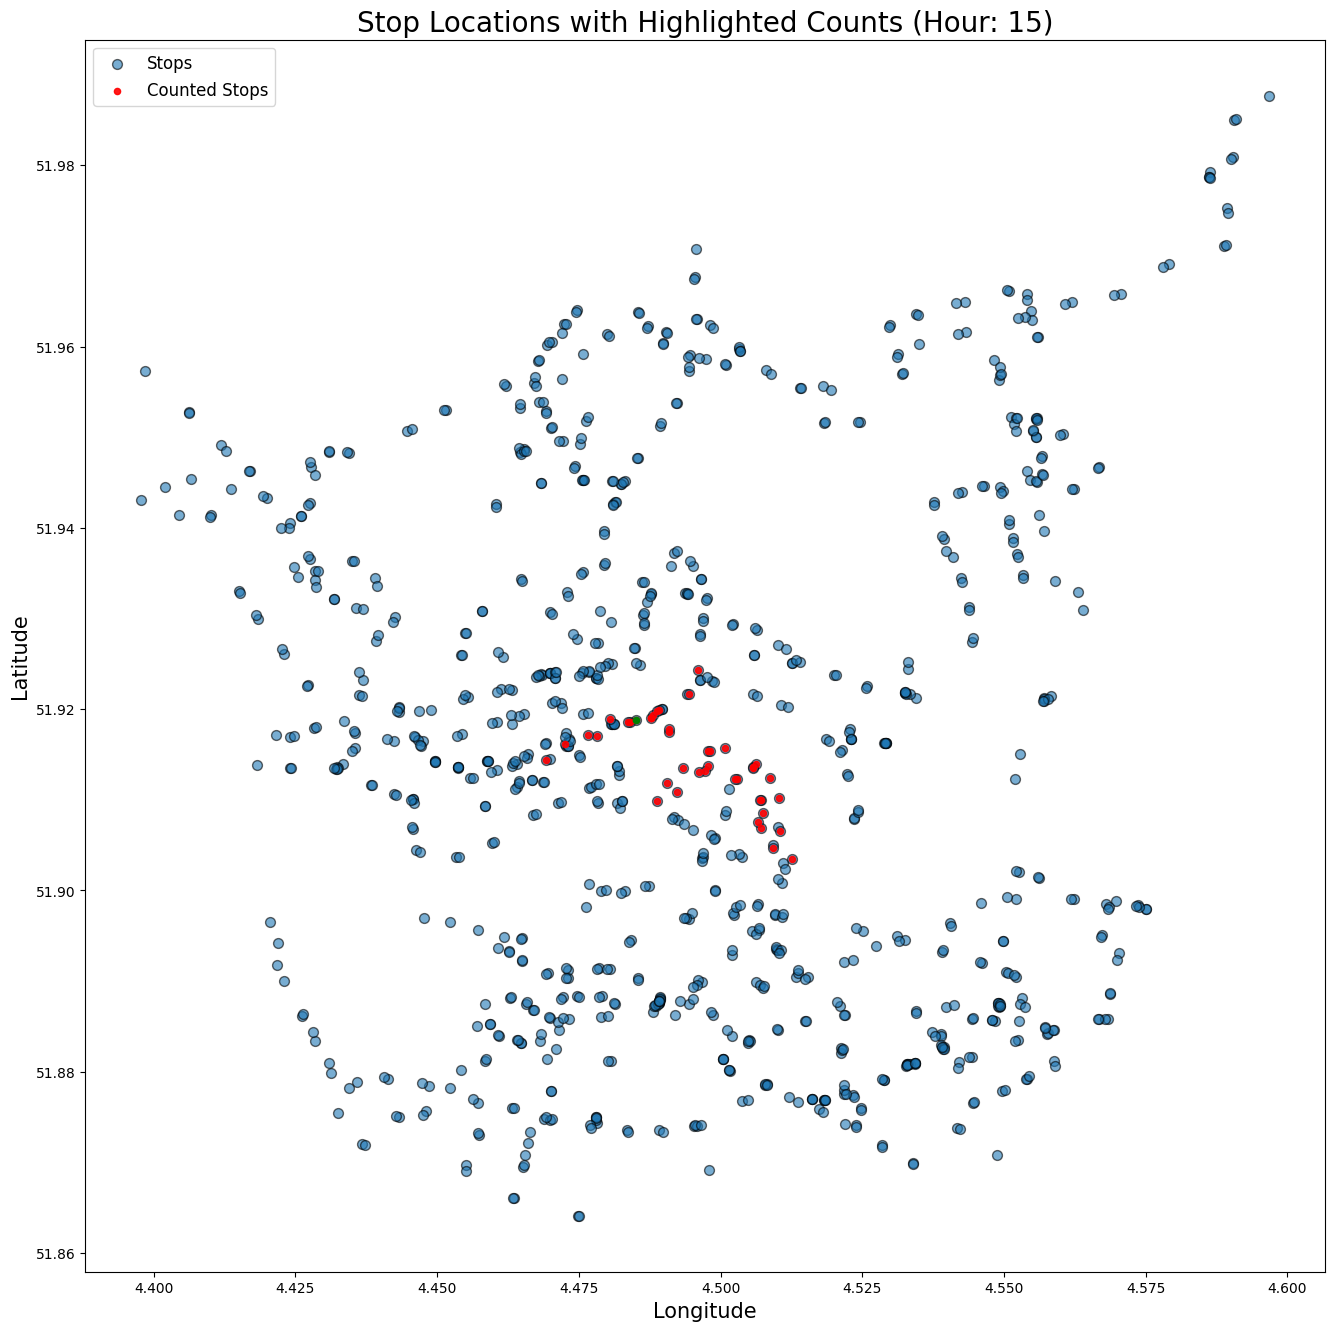

In [ ]:
# Filter the DataFrame based on the chosen conditions
df_to_plot = df_common[df_common['stop_id'].isin(pure_stop_times[(pure_stop_times['departure_hour'] == chosen_hour)]['stop_id'].unique())]

plt.figure(figsize=(16, 16))

# Plot the general stops
plt.scatter(df_to_plot['stop_lon'], df_to_plot['stop_lat'], label='Stops', alpha=0.6, edgecolor='k', s=50)

# Plot the stops with counts
plt.scatter(value_counts_df['stop_lon'], value_counts_df['stop_lat'], color='red', label='Counted Stops', alpha=0.9, s=20)
plt.scatter(value_counts_df['stop_lon'].iloc[0], value_counts_df['stop_lat'].iloc[0], color = 'green', alpha = 1, s = 20)

plt.title(f'Stop Locations with Highlighted Counts (Hour: {chosen_hour})', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.legend(loc='best', fontsize=12)
plt.show()

In [ ]:
def find_all_paths_within_weight_limit_tuple(graph, start_node, weight_limit):
    def dfs(current_node, current_path, current_weight, visited, current_route=None, current_departure_time=None):
        # If current_weight exceeds the limit, return
        if current_weight > weight_limit:
            return
        
        # Add the current path and weight to the list of all paths
        all_paths.append((tuple(current_path), current_weight))  # Convert list to tuple

        for neighbor in graph.successors(current_node):
            if neighbor not in visited:
                for edge_key in graph[current_node][neighbor]:
                    edge_data = graph[current_node][neighbor][edge_key]
                    edge_weight = edge_data['weight']
                    departure_time = edge_data['departure_time']
                    route_id = edge_data['route_id']
                    
                    # Continue only if the departure time is above the current departure time
                    if current_departure_time is None or departure_time > current_departure_time:
                        # Calculate waiting time if there is a change in route
                        if current_departure_time is not None:
                            waiting_time = (departure_time - current_departure_time).total_seconds()
                        else:
                            waiting_time = 0  # Handle this case according to your logic
                        
                        total_weight = current_weight + edge_weight + waiting_time
                        
                        # Add the neighbor to visited set
                        visited.add(neighbor)
                        # Append the neighbor to the current path
                        current_path.append(neighbor)
                        # Recursively call dfs
                        next_departure_time = departure_time + pd.Timedelta(seconds=edge_weight)
                        dfs(neighbor, current_path, total_weight, visited, route_id, next_departure_time)
                        # Remove the neighbor from the current path
                        current_path.pop()
                        # Remove the neighbor from visited set
                        visited.remove(neighbor)
    
    all_paths = []
    # Initialize the DFS with the start node
    dfs(start_node, [start_node], 0, set([start_node]))
    
    return all_paths

## Concept of minimized edges

In [ ]:
list_of_netwroks_own_w = []
list_of_stop_time = []
list_of_network_time = []
list_of_network_time_multi = []
puskas_list_of_weights = []
list_of_networks_puskas = []
stop_times_dic_for_each_hour = {}

pure_stop_times_next_day = pd.DataFrame()

for days in tqdm(range(1,8)):

    file_path = f"/mnt/common-ssd/mizsakma/tkom-data/gtfs_puskas/gtfs/gtfs_whole_week/gtfs ({days})"
    
    pure_stop_times = pd.read_csv(file_path + "/stop_times.txt", sep=",", dtype={'stop_headsign': 'object'})
    
    routes = pd.read_csv(file_path + "/routes.txt", sep=",")

    trips = pd.read_csv(file_path + "/trips.txt", sep=",", dtype={'route_id': 'object'})

    pure_stop_times = pure_stop_times.merge(df_2[['stop_id', 'clust', 'parent_station', 'stop_name']], on='stop_id', how='left')
    pure_stop_times.loc[pure_stop_times['parent_station'].notna(), 'stop_id'] = pure_stop_times['parent_station']
    pure_stop_times.loc['stop_id'] = pure_stop_times['parent_station']

    routes = routes[['route_id', 'route_type']]
    trips = trips[['route_id', 'trip_id', 'service_id']]  
    trips = pd.merge(trips, routes, on='route_id', how='right')
    pure_stop_times = pure_stop_times.merge(trips[['trip_id', 'route_id', 'route_type', 'service_id']], on='trip_id', how='left')

    pure_stop_times['stop_id_to'] = pure_stop_times.groupby((['trip_id', 'service_id', 'route_id', 'route_type']))['stop_id'].shift(-1)
    pure_stop_times['arrival_time_stop_to'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['arrival_time'].shift(-1)
    pure_stop_times['distance_travaled'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['shape_dist_traveled'].shift(-1)

    #deleting the terminals and loops
    pure_stop_times = pure_stop_times[pure_stop_times['arrival_time_stop_to'].notna()]
    pure_stop_times = pure_stop_times[pure_stop_times['stop_id'] != pure_stop_times['stop_id_to']]

    pure_stop_times['arrival_hour'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[0]))
    pure_stop_times['arrival_minute'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[1]))
    pure_stop_times['arrival_second'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[2]))

    pure_stop_times['departure_hour'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[0]))
    pure_stop_times['departure_minute'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[1]))
    pure_stop_times['departure_second'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[2]))
    
    pure_stop_times['arrival_time'] = pd.to_datetime({
        'year': 2020,  
        'month': 9,   
        'day': 20 + days,      
        'hour': pure_stop_times['arrival_hour'],
        'minute': pure_stop_times['arrival_minute'],
        'second': pure_stop_times['arrival_second'] })

    pure_stop_times['departure_time'] = pd.to_datetime({
        'year':2020,
        'month':9,
        'day': 20 + days,
        'hour':pure_stop_times['departure_hour'],
        'minute':pure_stop_times['departure_minute'],
        'second':pure_stop_times['departure_second']
    })

    pure_stop_times = pd.concat([pure_stop_times, pure_stop_times_next_day], ignore_index=True)
    pure_stop_times_next_day = pure_stop_times[pure_stop_times['departure_hour'] >= 24].copy()
    pure_stop_times_next_day['departure_hour'] = pure_stop_times_next_day['departure_hour'] % 24
    pure_stop_times = pure_stop_times[pure_stop_times['departure_hour'] < 24]
    



    
    pure_stop_times['edge_frequency'] = pure_stop_times.groupby(['stop_id', 'stop_id_to','departure_hour', 'trip_id']).transform('size')
    pure_stop_times['travel_duration'] = pure_stop_times['arrival_time'] - pure_stop_times['departure_time']
    pure_stop_times['travel_duration'] = pure_stop_times['travel_duration'].dt.total_seconds().astype(int)
    pure_stop_times['distance_travaled'] = pure_stop_times['distance_travaled'] - pure_stop_times['shape_dist_traveled']

    pure_stop_times = pure_stop_times[['trip_id', 'stop_id', 'stop_id_to','stop_sequence', 'route_id', 'route_type', 'travel_duration', 'distance_travaled', 'departure_hour', 'edge_frequency', 'departure_time', 'arrival_time']]
    
    pure_stop_times['weight_own'] = pure_stop_times['edge_frequency'] * ((pure_stop_times['distance_travaled'] + 1) / (pure_stop_times['travel_duration'] + 1))
    pure_stop_times['weight_freq'] = pure_stop_times['edge_frequency']
    pure_stop_times['weight_time'] = pure_stop_times.groupby(['stop_id', 'stop_id_to', 'departure_hour'])['travel_duration'].transform('mean')
    pure_stop_times['weight_dis'] = pure_stop_times.groupby(['stop_id', 'stop_id_to', 'departure_hour'])['distance_travaled'].transform('mean')

    #chacking the area around puskás
        
    for hour in range(24):
        pure_stop_times_network = pure_stop_times[pure_stop_times['departure_hour'] == hour]

        name = f"{days}_day_{hour}_hour_df"
        stop_times_dic_for_each_hour[name] = pure_stop_times_network
        
        network_own = nx.from_pandas_edgelist(
            pure_stop_times_network,
            source = 'stop_id',
            target ='stop_id_to',
            edge_attr = ['weight_own'],
            create_using = nx.DiGraph()
        )
        list_of_netwroks_own_w.append(network_own)

        network_time = nx.from_pandas_edgelist(
            pure_stop_times_network,
            source = 'stop_id',
            target = 'stop_id_to',
            edge_attr = ['weight_time'],
            create_using = nx.DiGraph()
        )
        list_of_network_time.append(network_time)

        puskas_stops_hour = puskas_stops[puskas_stops['departure_hour'] == hour]
        network_puskas = nx.from_pandas_edgelist(
            puskas_stops_hour,
            source = 'stop_id',
            target = 'stop_id_to',
            edge_attr = ['weight_time'],
            create_using = nx.DiGraph()
        )
        list_of_networks_puskas.append(network_puskas)

        network_time = nx.from_pandas_edgelist(
            pure_stop_times_network,
            source = 'stop_id',
            target = 'stop_id_to',
            edge_attr = ['travel_duration'],
            create_using = nx.DiGraph()
        )
        list_of_network_time_multi.append(network_time)

  0%|          | 0/7 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/common-ssd/mizsakma/tkom-data/gtfs_puskas/gtfs/gtfs_whole_week/gtfs (1)/stop_times.txt'

In [ ]:
df[df['stop_id'] == '008724']

stop_id       stop_name   stop_lat   stop_lon stop_code  location_type  \
1955  008724  Albertirsai út  47.500874  19.116122       NaN            NaN   
1956  008724      Várna utca  47.500874  19.116122       NaN            NaN   
1957  008724      Várna utca  47.500874  19.116122       NaN            NaN   
1958  008724     Kerepesi út  47.500874  19.116122       NaN            NaN   

     parent_station  wheelchair_boarding  stop_direction  clust  max_distance  \
1955         008724                  2.0             NaN    684    145.661574   
1956         008724                  1.0            45.0    684    145.661574   
1957         008724                  1.0          -128.0    684    145.661574   
1958         008724                  1.0           -10.0    684    145.661574   

      quant  
1955      4  
1956      4  
1957      4  
1958      4

In [ ]:
set(stop_id_to_list) #Need to add F01145, F02716, F02723, F02734, F02737, F01251, 009426, F02744, 016532, CSLMXKPB, F01182, F01328, F01735, F02737, F02744

{'008724',
 '016532',
 'CSLMXKPB',
 'F01182',
 'F01328',
 'F01735',
 'F02737',
 'F02744'}

In [ ]:
#min_stop_sequence = pure_stop_times.groupby('trip_id')['stop_sequence'].min().reset_index()
#pure_stop_times = pure_stop_times.merge(min_stop_sequence, on='trip_id', suffixes=('', '_min'))
#pure_stop_times = pure_stop_times[pure_stop_times['stop_sequence'] == pure_stop_times['stop_sequence_min']]
#pure_stop_times.drop(columns=['stop_sequence_min'], inplace=True)

Trying to create a new fully connected network, to know where shall I cluster more

Calculating the results

Concept of 15 min city - public transportation using DFS approach

If changing a vehicle counts

In [ ]:
def dfs_paths_with_changes(network, df, initial_node, current_path=None, current_weight=0, max_weight=900, node_results=None):
    if current_path is None:
        current_path = [initial_node]
        if node_results is None:
            node_results = set()
        node_results.add(initial_node)

    if current_weight <= max_weight:
        has_neighbors = False

        for neighbor in network.neighbors(initial_node):
            edge_weight = network[initial_node][neighbor].get('weight_time', 30)
            neighbor_trip_ids = df.loc[df['stop_id'] == neighbor, 'route_id'].tolist()

            if neighbor not in current_path:
                new_weight = current_weight + edge_weight

                current_trip_ids = df.loc[df['stop_id'] == initial_node, 'route_id'].tolist()

                if neighbor_trip_ids and any(trip_id != current_trip_ids for trip_id in neighbor_trip_ids):
                
                    new_weight += 120

                    #When the vehicle arrives
                    

                    #Calculating the difference between the arrivale of the vehicles


                if new_weight <= max_weight:
                    has_neighbors = True
                    yield from dfs_paths_with_changes(network, df, neighbor, current_path + [neighbor], new_weight, max_weight, node_results)
                else:
                    node_results.add(neighbor)

        if not has_neighbors:
            yield current_path, current_weight
            
    return list(node_results)

In [ ]:
def dfs_paths(network, initial_node, given_hour, current_path=None, current_routes=None, current_weight=0, max_weight=900, node_results=None):
    if current_path is None:
        current_path = [initial_node]
    if current_routes is None:
        current_routes = []

    if node_results is None:
        node_results = set()
    node_results.add(initial_node)

    if current_weight <= max_weight:
        has_neighbors = False

        for neighbor in network.neighbors(initial_node):
            if neighbor not in current_path:
                edge_weight = network[initial_node][neighbor].get('weight_time', 30)
                
                # Check conditions and update weights/routes as needed
                new_weight = current_weight + edge_weight

                if neighbor_trip_ids and any(trip_id not in current_routes for trip_id in neighbor_trip_ids):
                    new_weight += 120
                    # Additional logic related to route changes or conditions

                if new_weight <= max_weight:
                    has_neighbors = True
                    yield from dfs_paths(network, df, neighbor, given_hour, current_path + [neighbor], current_routes + neighbor_trip_ids, new_weight, max_weight, node_results)
                else:
                    node_results.add(neighbor)

        if not has_neighbors:
            yield current_path, current_routes, current_weight
            
    return list(node_results)

# Example usage:
# Assuming 'network' is a NetworkX graph and 'initial_node' is the starting node
# Modify as needed for your specific use case

In [ ]:
max_index = df_results_own[df_results_own['day'] == 4]['num_of_edges'].idxmax()
max_network = list_of_network_time[max_index]

kalvin_stop = df[df['stop_name'] == 'Kálvin tér M']['stop_id'].iloc[0]
df_day = int(df_results_time.loc[max_index]['day'])
df_hour = int(df_results_time.loc[max_index]['hour'])
dataframe = stop_times_dic_for_each_hour[f"{df_day}_day_{df_hour}_hour_df"]

In [ ]:
edge_list = []

kalvin = dfs_paths_with_changes(max_network, dataframe, kalvin_stop)
for path, weight in kalvin:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list.append((source_node, target_node))
edge_list = set(edge_list)

In [ ]:
node_list = []

for edge in edge_list:
    source_node, target_node = edge
    node_list.extend([source_node, target_node])

unique_nodes = set(node_list)
kalvin_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
kalvin = kalvin_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

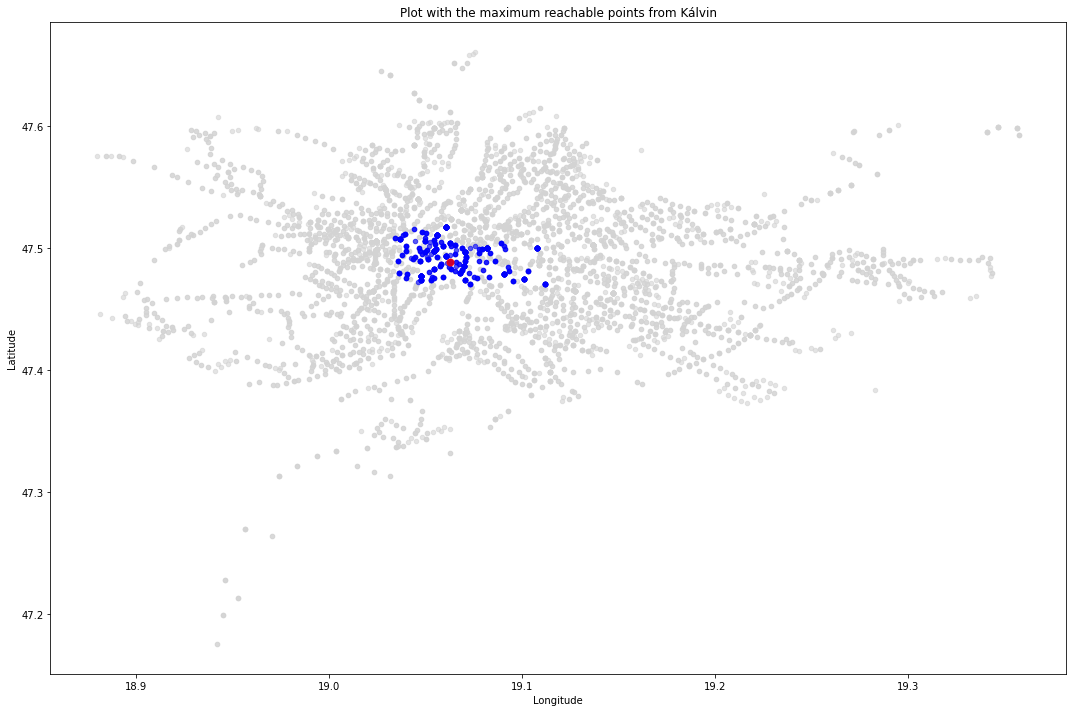

In [ ]:
lon = kalvin_nodes['stop_lon']
lat = kalvin_nodes['stop_lat']


plt.figure(figsize=(15, 10))
plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  
plt.scatter(lon, lat, c='blue', s=20, alpha=0.6)

highlight_lon = 19.06284
highlight_lat = 47.489173
plt.scatter(highlight_lon, highlight_lat, c='red', s=50, alpha=0.8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Kálvin')
plt.grid(False) 
plt.tight_layout() 
plt.show()

In [ ]:
edge_list = []

max_index = df_results_own[df_results_own['day'] == 4]['num_of_edges'].idxmax()
max_network = list_of_network_time[max_index]

örs_stop = df[df['stop_name'] == 'Örs vezér tere M+H']['stop_id'].iloc[0]
df_day = int(df_results_own.loc[max_index]['day'])
df_hour = int(df_results_own.loc[max_index]['hour'])
dataframe = stop_times_dic_for_each_hour[f"{df_day}_day_{df_hour}_hour_df"]

örs = dfs_paths_with_changes(max_network, dataframe, örs_stop)
for path, weight in örs:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list.append((source_node, target_node))
edge_list = set(edge_list)

node_list = []

for edge in edge_list:
    source_node, target_node = edge
    node_list.extend([source_node, target_node])

unique_nodes = set(node_list)
örs_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
örs = örs_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


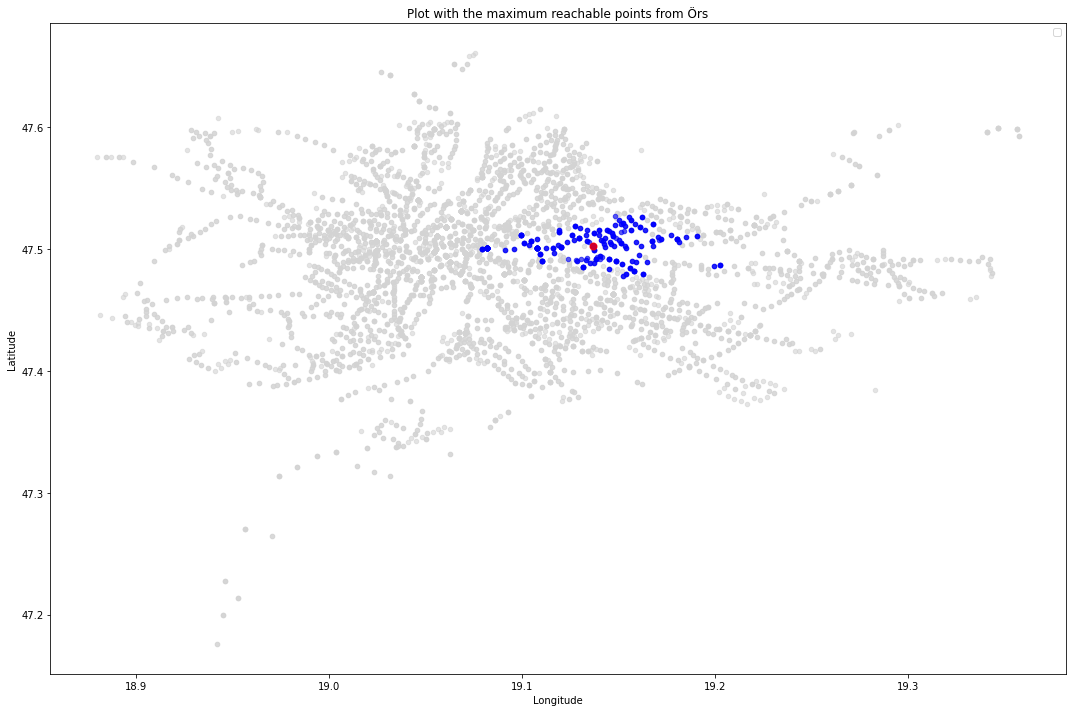

In [ ]:
lon = örs_nodes['stop_lon']
lat = örs_nodes['stop_lat']

plt.figure(figsize=(15, 10))

plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  
plt.scatter(lon, lat, c='blue', s=20, alpha=0.6)

highlight_lon = 19.136843
highlight_lat = 47.502448
plt.scatter(highlight_lon, highlight_lat, c='red', s=50, alpha=0.8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Örs')
plt.grid(False) 
plt.legend()
plt.tight_layout() 
plt.show()

In [ ]:
df[df['stop_name'] == 'Puskás Ferenc Stadion M']

stop_id                stop_name   stop_lat  stop_lon stop_code  \
1919  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1920  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1921  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1922  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1925  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1926  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1927  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1928  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1929  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1930  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1933  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1934  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1935  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1938  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   
1940  F01319  Puskás Ferenc Stadion M  47.500654  19.10785       NaN   

      location_type parent_station  wheelchair_boarding  stop_direction  \
1919            NaN         F01319                  1.0           171.0   
1920            NaN         F01319                  NaN             NaN   
1921            NaN         F01319                  1.0             NaN   
1922            NaN         F01319                  2.0             NaN   
1925            NaN         F01319                  2.0             NaN   
1926            NaN         F01319                  1.0            78.0   
1927            NaN         F01319                  1.0           169.0   
1928            NaN         F01319                  1.0             NaN   
1929            NaN         F01319                  1.0           -10.0   
1930            NaN         F01319                  1.0           -14.0   
1933            NaN         F01319                  1.0             NaN   
1934            NaN         F01319                  1.0           -97.0   
1935            NaN         F01319                  1.0             NaN   
1938            NaN         F01319                  1.0             NaN   
1940            NaN         F01319                  2.0             NaN   

      clust  max_distance  quant  
1919    676    460.617681     22  
1920    676    460.617681     22  
1921    676    460.617681     22  
1922    676    460.617681     22  
1925    676    460.617681     22  
1926    676    460.617681     22  
1927    676    460.617681     22  
1928    676    460.617681     22  
1929    676    460.617681     22  
1930    676    460.617681     22  
1933    676    460.617681     22  
1934    676    460.617681     22  
1935    676    460.617681     22  
1938    676    460.617681     22  
1940    676    460.617681     22

In [ ]:
#How the poeople could travel from which was on the 4th day and in the 23rd hour

edge_list_puskas = []
node_list_puskas = []

df_day = 3
df_hour = 23

max_index = 24 * df_day + df_hour + 1
max_network = list_of_network_time[max_index]

puskas_stops = df[df['stop_name'] == 'Puskás Ferenc Stadion M']['stop_id'].iloc[0]
dataframe = stop_times_dic_for_each_hour[f"{df_day}_day_{df_hour}_hour_df"]

puskas = dfs_paths_with_changes(max_network, dataframe, puskas_stops)

for path, weight in puskas:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list_puskas.append((source_node, target_node))
edge_list_puskas = set(edge_list_puskas)

for edge in edge_list_puskas:
    source_node, target_node = edge
    node_list_puskas.extend([source_node, target_node])

unique_nodes = set(node_list_puskas)
puskas_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
puskas = puskas_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


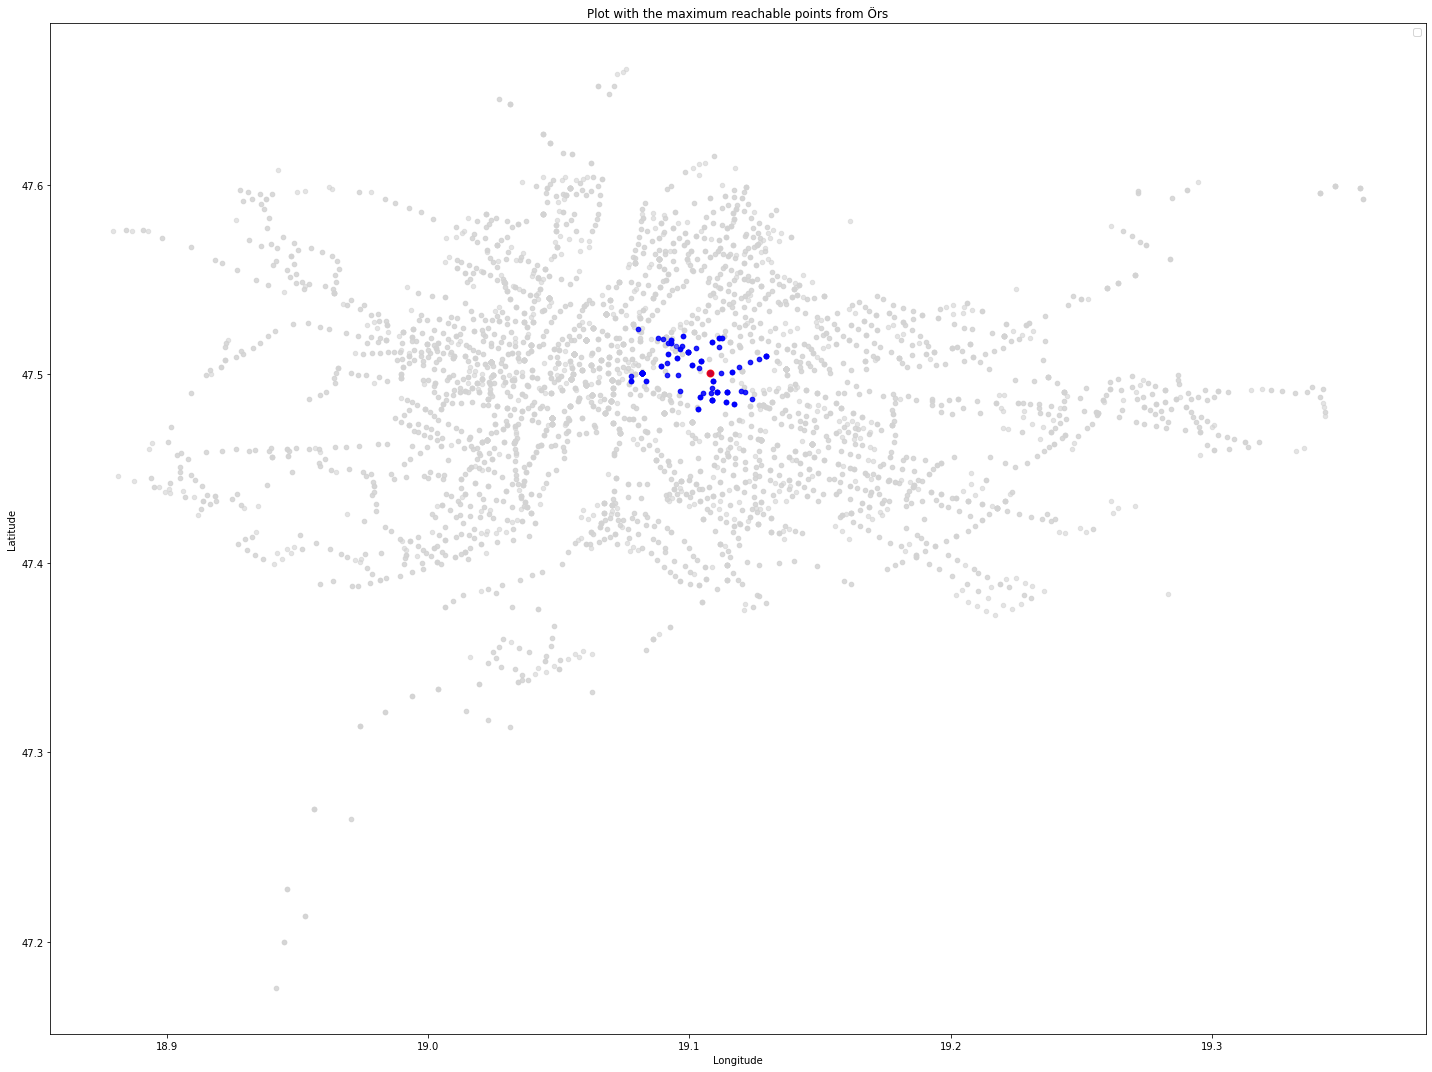

In [ ]:
lon = puskas_nodes['stop_lon']
lat = puskas_nodes['stop_lat']

plt.figure(figsize=(20, 15))

plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  
plt.scatter(lon, lat, c='blue', s=20, alpha=0.6)

highlight_lon = 19.10785
highlight_lat = 47.500654

plt.scatter(highlight_lon, highlight_lat, c='red', s=50, alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Örs')
plt.grid(False) 
plt.legend()
plt.tight_layout() 
plt.show()

In [ ]:
edge_list_puskas_2 = []
node_list_puskas_2 = []

df_day = 3
df_hour = 23

max_index = 24 * df_day + df_hour + 1
max_network = list_of_network_time[max_index]

puskas_stops = df[df['stop_name'] == 'Puskás Ferenc Stadion M']['stop_id'].iloc[0]
dataframe = stop_times_dic_for_each_hour[f"{df_day}_day_{df_hour}_hour_df"]

puskas_multi = dfs_paths_with_changes(max_network, dataframe, puskas_stops)

for path, weight in puskas_multi:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list_puskas_2.append((source_node, target_node))
edge_list_puskas_multi = set(edge_list_puskas_2)

for edge in edge_list_puskas_multi:
    source_node, target_node = edge
    node_list_puskas_2.extend([source_node, target_node])

unique_nodes = set(node_list_puskas_2)
puskas_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
puskas_multi = puskas_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

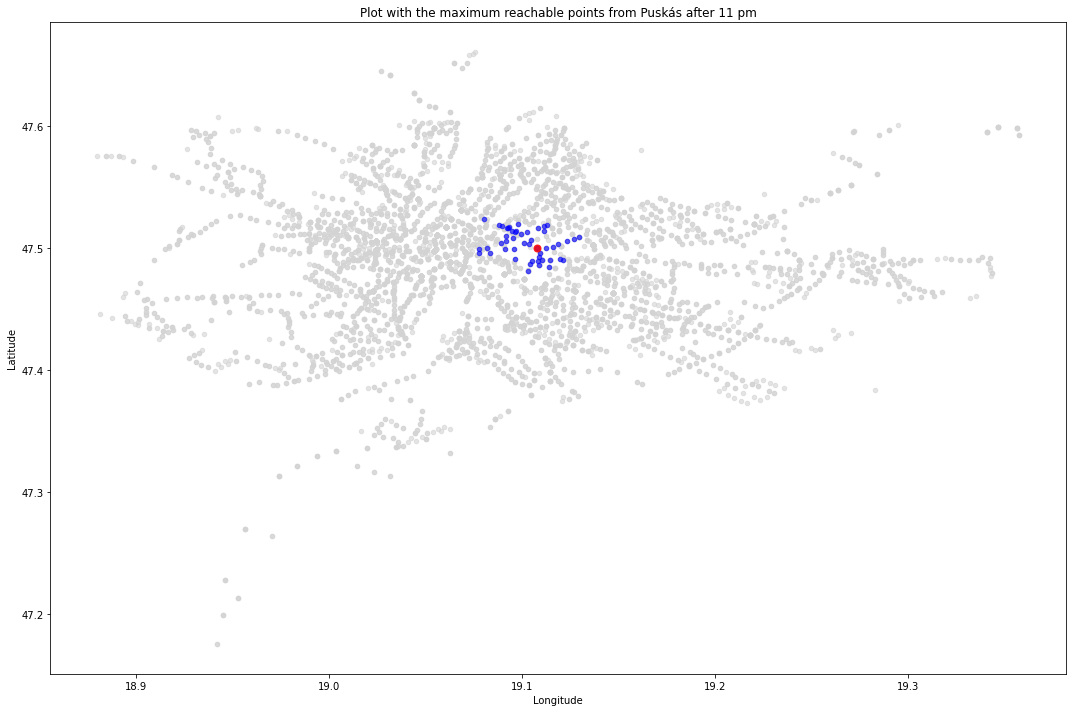

In [ ]:
lon = puskas_multi['stop_lon']
lat = puskas_multi['stop_lat']

plt.figure(figsize=(15, 10))

plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  
plt.scatter(lon, lat, c='blue', s=20, alpha=0.6)

highlight_lon = 19.10785
highlight_lat = 47.500654

plt.scatter(highlight_lon, highlight_lat, c='red', s=50, alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Puskás after 11 pm')
plt.grid(False) 
plt.tight_layout() 
plt.show()

## Multi graphs

In [ ]:
def dfs_paths_with_changes_multi(network, df, initial_node, current_path=None, current_weight=0, max_weight=900, node_results=None):
    if current_path is None:
        current_path = [initial_node]
        if node_results is None:
            node_results = set()
        node_results.add(initial_node)

    if current_weight <= max_weight:
        has_neighbors = False

        for neighbor in network.neighbors(initial_node):
            edge_weight = network[initial_node][neighbor].get('travel_duration', 30)
            neighbor_trip_ids = df.loc[df['stop_id'] == neighbor, 'trip_id'].tolist()

            if neighbor not in current_path:
                new_weight = current_weight + edge_weight

                current_trip_ids = df.loc[df['stop_id'] == initial_node, 'trip_id'].tolist()
                if neighbor_trip_ids and any(trip_id != current_trip_ids for trip_id in neighbor_trip_ids):
                
                    new_weight += 120

                if new_weight <= max_weight:
                    has_neighbors = True
                    yield from dfs_paths_with_changes_multi(network, df, neighbor, current_path + [neighbor], new_weight, max_weight, node_results)
                else:
                    node_results.add(neighbor)

        if not has_neighbors:
            yield current_path, current_weight
            
    return list(node_results)

In [ ]:
edge_list_puskas_multi = []
node_list_puskas_multi = []

df_day = 3
df_hour = 23

max_index = 24 * df_day + df_hour + 1
max_network = list_of_network_time_multi[max_index]

puskas_stops = df[df['stop_name'] == 'Puskás Ferenc Stadion M']['stop_id'].iloc[0]
dataframe = stop_times_dic_for_each_hour[f"{df_day}_day_{df_hour}_hour_df"]

puskas_multi = dfs_paths_with_changes_multi(max_network, dataframe, puskas_stops)

for path, weight in puskas_multi:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list_puskas_multi.append((source_node, target_node))
edge_list_puskas_multi = set(edge_list_puskas_multi)

for edge in edge_list_puskas_multi:
    source_node, target_node = edge
    node_list_puskas_multi.extend([source_node, target_node])

unique_nodes = set(node_list_puskas_multi)
puskas_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
puskas_multi = puskas_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

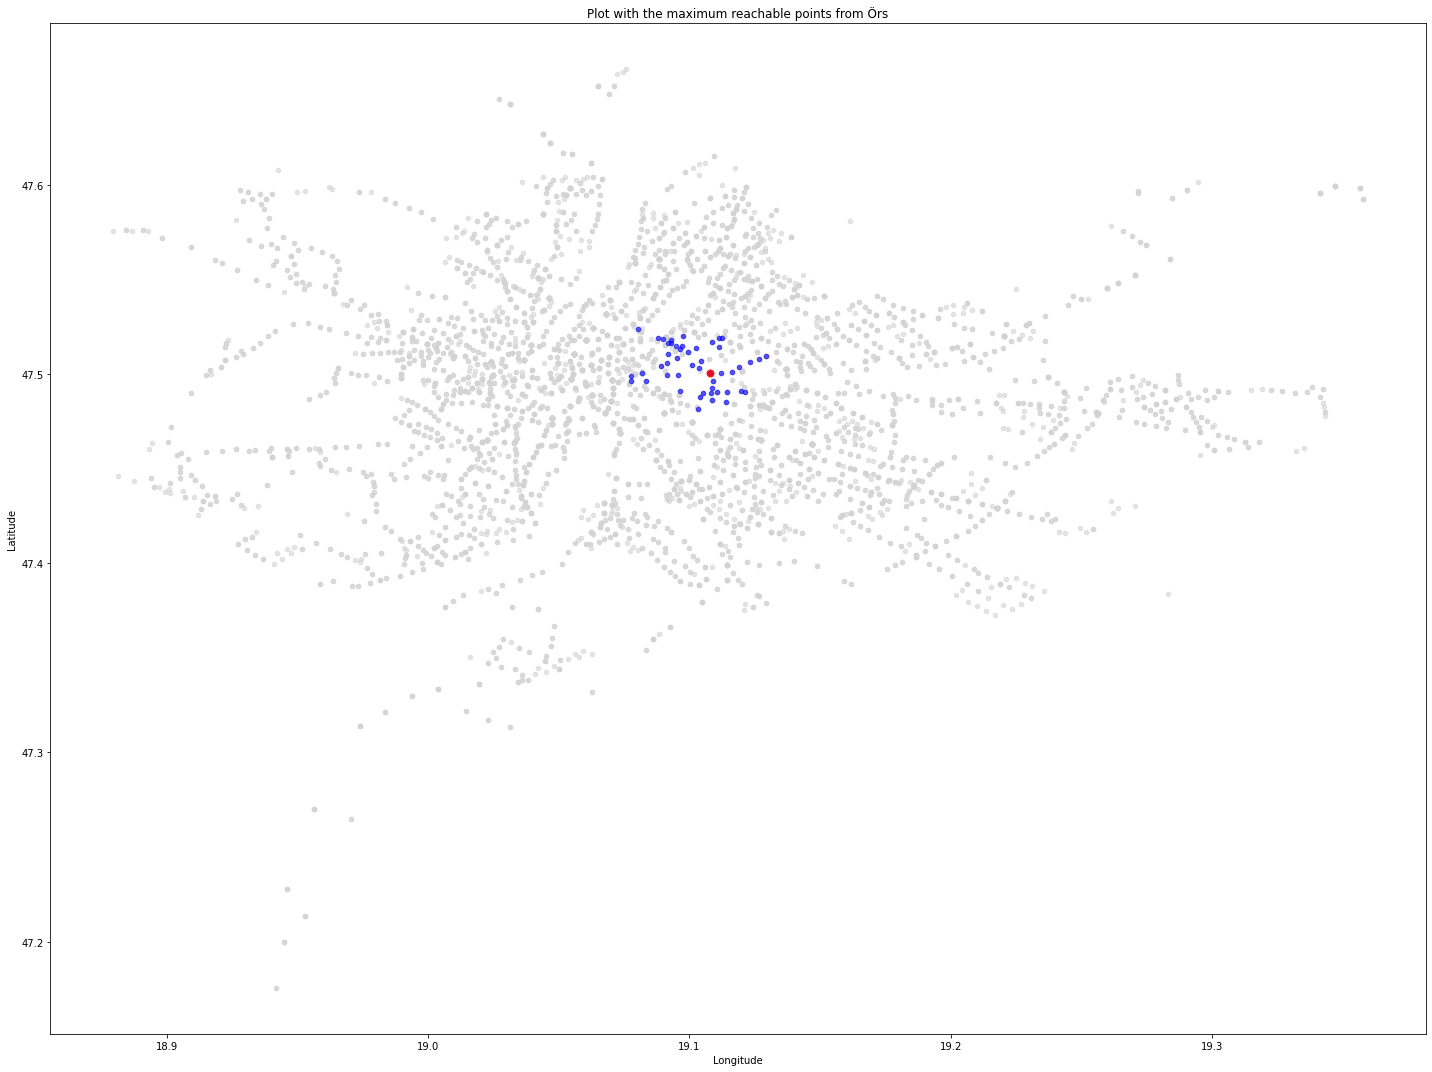

In [ ]:
lon = puskas_multi['stop_lon']
lat = puskas_multi['stop_lat']

plt.figure(figsize=(20, 15))

plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  
plt.scatter(lon, lat, c='blue', s=20, alpha=0.6)

highlight_lon = 19.10785
highlight_lat = 47.500654

plt.scatter(highlight_lon, highlight_lat, c='red', s=50, alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Örs')
plt.grid(False) 
plt.tight_layout() 
plt.show()

In [ ]:
edge_list_puskas_multi = []
node_list_puskas_multi = []

df_day = 3
df_hour = 15

max_index = 24 * df_day + df_hour
max_network = list_of_network_time_multi[max_index]

puskas_stops = df[df['stop_name'] == 'Kálvin tér M']['stop_id'].iloc[0]
dataframe = stop_times_dic_for_each_hour[f"{df_day}_day_{df_hour}_hour_df"]

puskas_multi = dfs_paths_with_changes_multi(max_network, dataframe, puskas_stops)

for path, weight in puskas_multi:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list_puskas_multi.append((source_node, target_node))
edge_list_puskas_multi = set(edge_list_puskas_multi)

for edge in edge_list_puskas_multi:
    source_node, target_node = edge
    node_list_puskas_multi.extend([source_node, target_node])

unique_nodes = set(node_list_puskas_multi)
puskas_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
puskas_multi = puskas_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

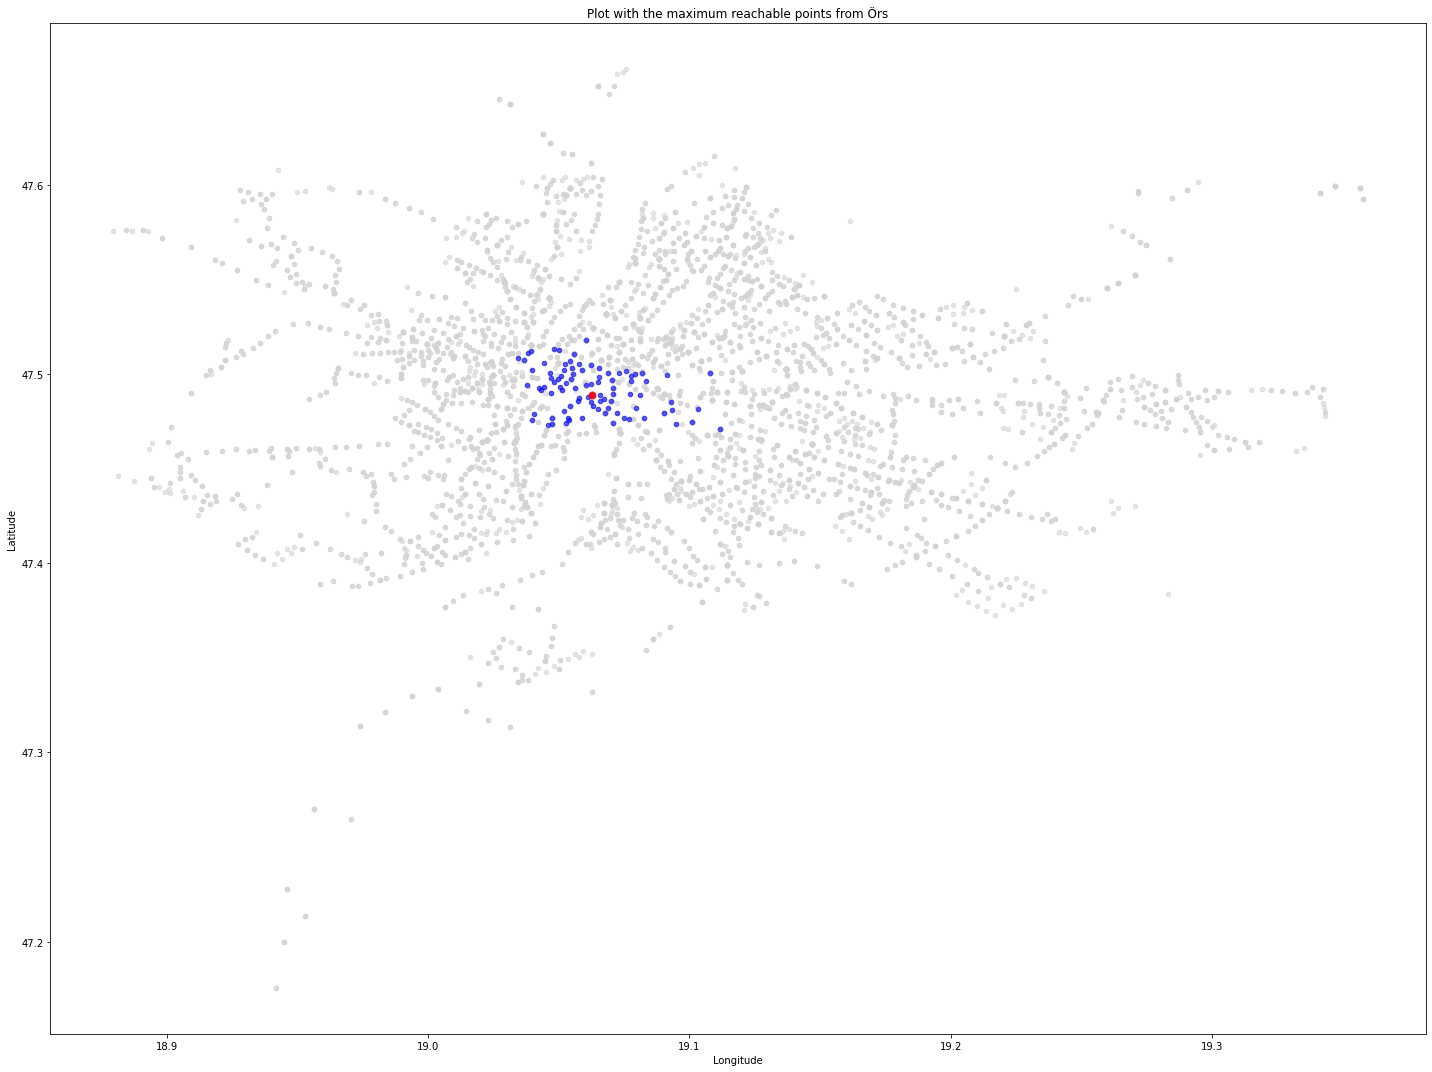

In [ ]:
lon = puskas_multi['stop_lon']
lat = puskas_multi['stop_lat']

plt.figure(figsize=(20, 15))

plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  
plt.scatter(lon, lat, c='blue', s=20, alpha=0.6)

highlight_lon = 19.06284
highlight_lat = 47.489173

plt.scatter(highlight_lon, highlight_lat, c='red', s=50, alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Örs')
plt.grid(False) 
plt.tight_layout() 
plt.show()